## Machine Learning Driven User Segmentation

#### Objective

The objective of this project is to construct a machine learning model that accurately classifies entities into predefined segments, learning from an existing labeled dataset. The steps to achieve this objective include:

1. Data Exploration: Investigate the dataset to understand the feature distributions, handle missing values, and explore feature interrelationships.

2. Preprocessing: Prepare the data for modeling by imputing missing values, encoding categorical variables, normalizing numerical inputs, and addressing outliers.

3. Feature Engineering: Enhance the model's predictive power by selecting and possibly constructing key features that have the most significant impact on classification.

4. Model Development: Identify and test various classification algorithms suitable for the data's characteristics, such as ensemble methods, SVMs, or neural networks.

5. Model Training and Validation: Train the models on the dataset and validate their performance with metrics like accuracy and F1-score, employing cross-validation for robustness.

6. Hyperparameter Optimization: Refine the models by tuning hyperparameters to improve accuracy and reduce overfitting.

7. Model Selection: Evaluate and select the optimal model based on performance metrics, balancing predictive power with computational efficiency.

8. Model Deployment: Implement the final model to classify new data, aligning its predictive segmentation with the established categories.

The goal is to leverage the existing segmentation framework to inform the model, ensuring that it not only predicts accurately but also aligns with the established understanding of the segment structures.


#### Importing libraries

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
#Importing libraries
import pandas as pd, numpy as np, matplotlib.pyplot as plt, os, seaborn as sns
from numpy import asarray
from sklearn import preprocessing
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score,ConfusionMatrixDisplay,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from scipy.stats import uniform,randint
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from scipy.stats import chi2_contingency

#### Data exploration

In [373]:
# Loading Data
train = pd.read_csv(os.path.join( 'Train.csv'))
test = pd.read_csv(os.path.join( 'Test.csv'))
df = pd.concat([train,test]).drop(columns=['ID'])

df.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


In [374]:
df.shape

(10695, 10)

In [375]:
#stats per numerical column
round(df.describe(),2)

,Age,Work_Experience,Family_Size
count,10695.00,9597.00,10247.00
mean,43.51,2.62,2.84
std,16.77,3.39,1.54
min,18.00,0.00,1.00
25%,30.00,0.00,2.00
50%,41.00,1.00,3.00
75%,53.00,4.00,4.00
max,89.00,14.00,9.00


In [376]:
#Check for nulls and display unique values
print('no. of nulls:\n', df.isnull().sum().sort_values(ascending=False))

#Dropping nulls
df =df.dropna()

#unique vals
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
print('\n',df_uniques)

no. of nulls:
 Work_Experience    1098
Family_Size         448
Ever_Married        190
Profession          162
Var_1               108
Graduated           102
Gender                0
Age                   0
Spending_Score        0
Segmentation          0
dtype: int64

                  Unique Values
Variable                      
Gender                       2
Ever_Married                 2
Age                         67
Graduated                    2
Profession                   9
Work_Experience             15
Spending_Score               3
Family_Size                  9
Var_1                        7
Segmentation                 4


In [377]:
#Categorizing variables
#Binary
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)

#Ordinal variables
ordinal_variables = ['Spending_Score']

#Categorical variables
categorical_variables = list(set(df_uniques[(8 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)- set(ordinal_variables))
categorical_variables.remove("Segmentation")
categorical_variables.append("Profession")

#Numeric variables
numerical_variables = list(set(df.columns) - set(ordinal_variables) - set(categorical_variables) - set(binary_variables))
numerical_variables.remove('Segmentation')

#### Visualization

##### Distribution of binary features

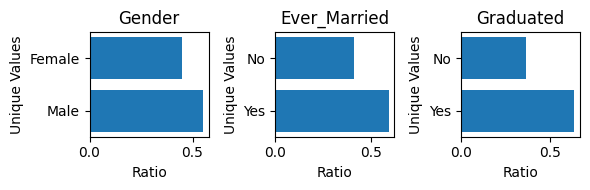

In [378]:
# create a subplot with the appropriate number of rows and columns
fig, axs = plt.subplots(1, len(binary_variables), figsize=(6, 2))

# iterate over each binary variable
for i, variable in enumerate(binary_variables):
    # calculate the counts of unique values
    counts = df[variable].value_counts()
    
    # calculate the ratios of counts
    ratios = counts / counts.sum()
    
    # plot the ratios as a horizontal bar chart
    axs[i].barh(ratios.index, ratios.values)
    axs[i].set_xlabel('Ratio')
    axs[i].set_ylabel('Unique Values')
    axs[i].set_title(variable)
    
# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()

##### Distribution of categorical features

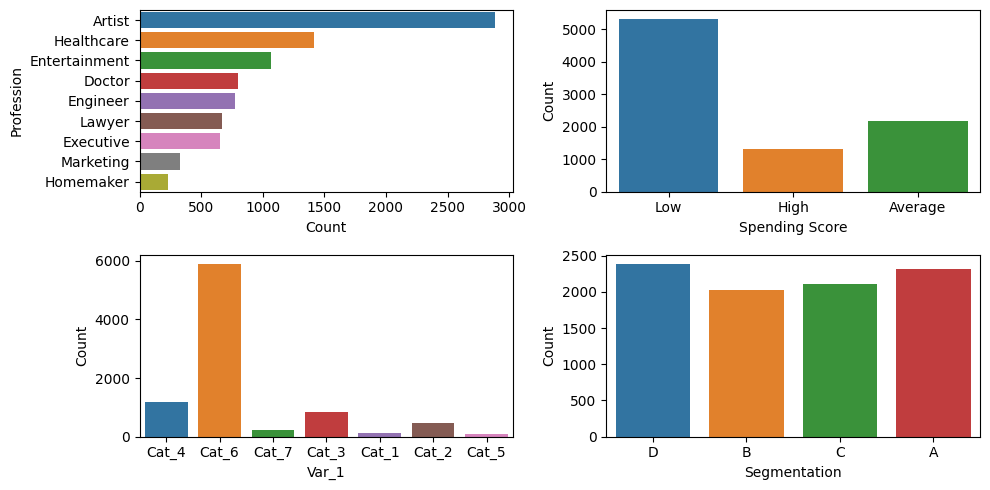

In [379]:
# get the value counts for each profession
x = df['Profession'].value_counts()

# create a subplot with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# plot the bar chart of profession counts
sns.barplot(x=x, y=x.index, ax=axs[0, 0])
axs[0, 0].set_xlabel('Count')
axs[0, 0].set_ylabel('Profession')

# plot the count plot of spending score
sns.countplot(df, x='Spending_Score', ax=axs[0, 1])
axs[0, 1].set_xlabel('Spending Score')
axs[0, 1].set_ylabel('Count')

# plot the count plot of var_1
sns.countplot(df, x='Var_1', ax=axs[1, 0])
axs[1, 0].set_xlabel('Var_1')
axs[1, 0].set_ylabel('Count')

# plot the count plot of segmentation
sns.countplot(df, x='Segmentation', ax=axs[1, 1])
axs[1, 1].set_xlabel('Segmentation')
axs[1, 1].set_ylabel('Count')

# adjust the layout of the subplots
plt.tight_layout()

# show the plot
plt.show()


##### Pair Plot Analysis for numerical features

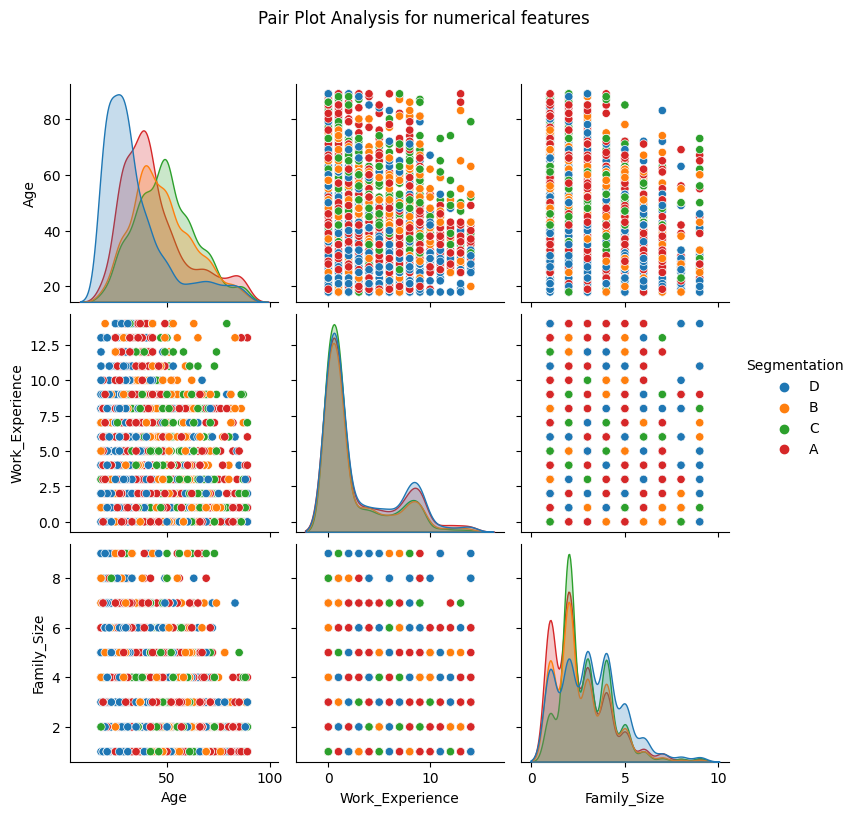

In [380]:
#create an array of segmentation classes
seg=[x for x in df['Segmentation'].unique()]

#Add labels to the segmentation classes
label={}
for x in range(len(seg)):
    label[x] = seg[x]

#Plotting pairplot
plotdata = sns.pairplot(df.replace({'Segmentation' : label}), hue = 'Segmentation')
with sns.color_palette("Set3"):
    plotdata.fig.suptitle("Pair Plot Analysis for numerical features", y = 1.08)

##### Cramer's v correlation matrix

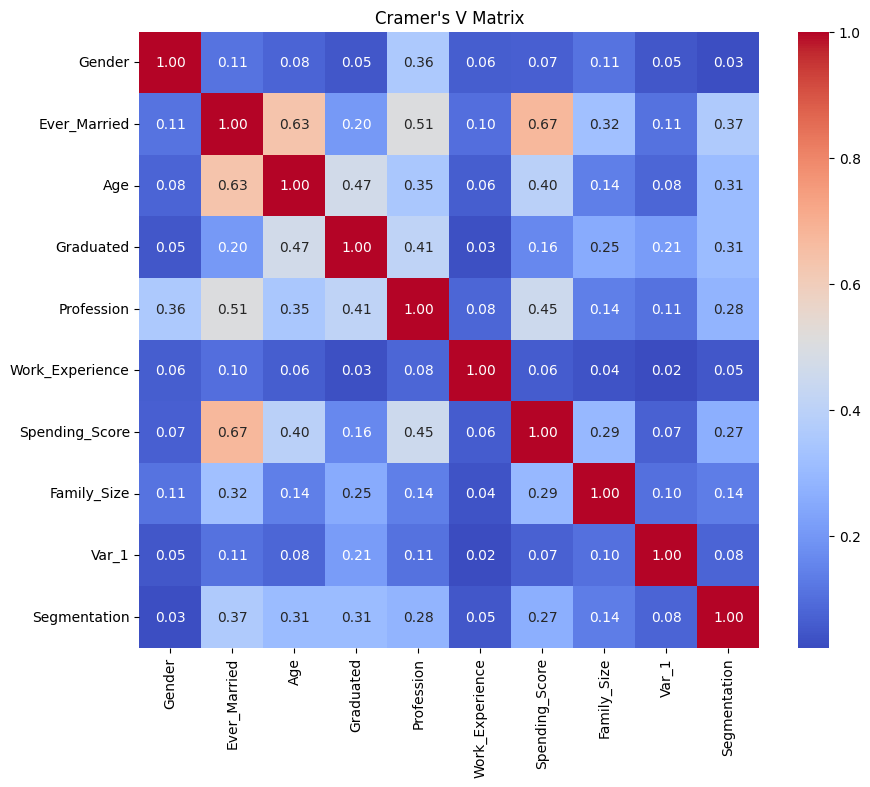

In [381]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

def cramers_v_matrix(df):
    columns = df.columns
    n = len(columns)
    matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            matrix[i, j] = cramers_v(df[columns[i]], df[columns[j]])
    return pd.DataFrame(matrix, columns=columns, index=columns)

cramer_matrix = cramers_v_matrix(df)
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Cramer\'s V Matrix')
plt.show()

#### Preprocessing for ML

##### Ordinal encoding

In [382]:
encoded=df
ordinalenc= preprocessing.OrdinalEncoder()
for x in ordinal_variables:
    ordinalenc.fit(asarray(encoded[x]).reshape(-1,1))
    encoded[x]=ordinalenc.transform(asarray(encoded[x]).reshape(-1,1))

##### One hot encoding

In [383]:
ohcols=[]

for x in binary_variables:
    ohcols.append(x)
for y in categorical_variables:
    ohcols.append(y)

for col in ohcols:
    encoded[col] = pd.Categorical(encoded[col])
encoded = pd.get_dummies(encoded,columns = ohcols)

##### label encoding

In [384]:
le = preprocessing.LabelEncoder() 
encoded['Segmentation']= le.fit_transform(encoded['Segmentation'])

##### MinMax scaling

In [385]:
scaler= preprocessing.MinMaxScaler()
encoded[numerical_variables] = scaler.fit_transform(encoded[numerical_variables])
encoded.head()

,Age,Work_Experience,Spending_Score,Family_Size,Segmentation,Gender_Female,Gender_Male,Ever_Married_No,Ever_Married_Yes,Graduated_No,...,Var_1_Cat_7,Profession_Artist,Profession_Doctor,Profession_Engineer,Profession_Entertainment,Profession_Executive,Profession_Healthcare,Profession_Homemaker,Profession_Lawyer,Profession_Marketing
0,0.056338,0.071429,2.0,0.375,3,False,True,True,False,True,...,False,False,False,False,False,False,True,False,False,False
2,0.690141,0.071429,2.0,0.000,1,True,False,False,True,False,...,False,False,False,True,False,False,False,False,False,False
3,0.690141,0.000000,1.0,0.125,1,False,True,False,True,False,...,False,False,False,False,False,False,False,False,True,False
5,0.535211,0.000000,0.0,0.125,2,False,True,False,True,True,...,False,True,False,False,False,False,False,False,False,False
6,0.197183,0.071429,2.0,0.250,2,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,False


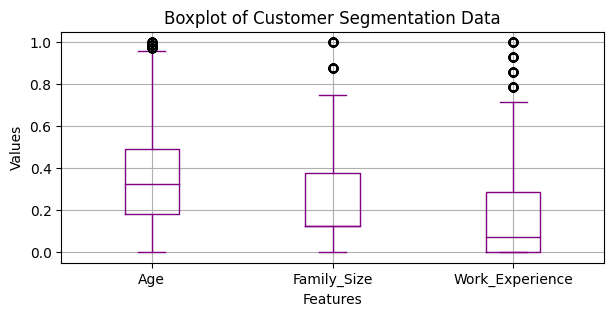

In [386]:
# create the boxplot
encoded[numerical_variables].boxplot(figsize=(7,3), color='purple')

# add labels and title
plt.xlabel('Features')
plt.ylabel('Values')
plt.title('Boxplot of Customer Segmentation Data')

# show the plot
plt.show()


##### Removing outliers

In [387]:
# # Define a function to calculate IQR
# def remove_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_limit = Q1 - 1.5 * IQR
#     upper_limit = Q3 + 1.5 * IQR
#     return df[(df[column] >= lower_limit) & (df[column] <= upper_limit)]

# # Apply the function to the columns
# df = remove_outliers(df, 'Age')
# df = remove_outliers(df, 'Work_Experience')
# df = remove_outliers(df, 'Family_Size')

The decision to retain outliers was motivated by their positive impact on the performance of the XGBoost model. This is attributable to XGBoost's inherent strength in accurately predicting rare events. Moreover, XGBoost demonstrated superior performance even after outlier removal, further substantiating the decision to preserve them.

#### Preliminiary actions for ML

In [388]:
# Splitting the data into encoded features (X) and encoded target variable (y)
y = encoded['Segmentation']
X = encoded.drop('Segmentation', axis=1)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

##### Creating error metrics calculator function

In [389]:
def error_metrics(y_test,y_pred,le,scores):
    y_test_original = le.inverse_transform(y_test)
    y_pred_original = le.inverse_transform(y_pred)
    #print("Classification Report: \n", classification_report(y_test_original, y_pred_original))
    print("Accuracy Score: ",accuracy_score(y_test,y_pred))
    print('Average cross-validation score: ', scores.mean())
    print("Precision Score: ",precision_score(y_test,y_pred,average='weighted'))
    print("Recall Score: ",recall_score(y_test,y_pred,average='weighted'))
    print("F1 Score: ",f1_score(y_test,y_pred,average='weighted'))


##### Creating a confusion matrix plot function

In [390]:
def plot_confusion_matrix(y_test,y_pred,le):
    y_test_original = le.inverse_transform(y_test)
    y_pred_original = le.inverse_transform(y_pred)
    cm=confusion_matrix(y_test_original,y_pred_original)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_test_original))
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()

#### Machine learning


For a dataset with less than 10k cells and 9 features, some of the best models for classification are logistic regression, decision trees, and k-nearest neighbors (KNN). Logistic regression is a simple and efficient model that works well for binary classification problems. Decision trees are easy to interpret and can handle both categorical and numerical data. KNN is a non-parametric model that can handle both classification and regression problems and is particularly useful when the decision boundary is irregular. Ultimately, the best model choice depends on the specific problem and the characteristics of the dataset.

##### Logistic Regression

Logistic Regression is a statistical model that uses a logistic function to model a binary dependent variable. Although it's named 'regression', it's actually used for classification problems. Here's a simplified explanation of how it works:

1. **Linear Combination of Features**: Similar to linear regression, logistic regression combines the input features in a linear way, i.e., it multiplies each feature with a coefficient and sums them up, often adding an intercept term.

2. **Logistic Transformation**: The result of the linear combination is then passed through a logistic (or sigmoid) function, which maps the input between 0 and 1. This output can be interpreted as the probability of the positive class.

3. **Binary Outcome**: A threshold (usually 0.5) is applied to the output probability. If the probability is greater than the threshold, the model predicts the positive class, otherwise, it predicts the negative class.

4. **Estimation of Coefficients**: The coefficients of the logistic regression model are typically estimated using maximum likelihood estimation. This method finds the coefficients that make the observed data most probable.

Creating model and Finding the best hyperparameters for the model

In [391]:
# create an instance of the model
logreg = LogisticRegression()

# fit the model on the training data
logreg.fit(X_train, y_train)

# define the hyperparameter grid
param_grid = {'C': uniform(loc=0, scale=4),
              'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'max_iter': [100, 500, 1000, 5000]}

# create a randomized search object
random_search = RandomizedSearchCV(estimator=logreg, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)

# fit the randomized search object on the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print(random_search.best_params_)

{'C': 0.6028701758617179, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


Create an instance of the model with the best hyperparameters

In [392]:
logreg = LogisticRegression(C=random_search.best_params_['C'], penalty=random_search.best_params_['penalty'], solver=random_search.best_params_['solver'], max_iter=random_search.best_params_['max_iter'])

#fit the model on the training data
logreg.fit(X_train, y_train)

# predict the target variable for the test data
y_pred = logreg.predict(X_test)

# perform cross-validation
scores = cross_val_score(logreg, X_train, y_train, cv=5)

# calculate Logistic regression's error metrics
error_metrics(y_test, y_pred,le,scores)

Accuracy Score:  0.4610099622122982
Average cross-validation score:  0.47240601686889566
Precision Score:  0.44467015483016975
Recall Score:  0.4610099622122982
F1 Score:  0.4421376982384584


Compute F1 score

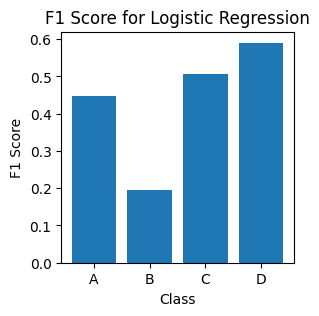

In [393]:
# predict the target variable for the test data
y_pred = logreg.predict(X_test)

# calculate the f1 score for each class
f1_scores = f1_score(y_test, y_pred, average=None)

# get the unique class labels
class_labels = le.inverse_transform(logreg.classes_)

# plot the f1 score for each class
plt.figure(figsize=[3,3])
plt.bar(class_labels, f1_scores)
plt.title('F1 Score for Logistic Regression')
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.show()

Here the F1 Score for logistic regression indicated that the model has:

1. **Imbalanced Performance**: The F1 scores vary significantly between classes, this indicates that the model is performing better on some classes than others. This could be due to a class imbalance in the training data, or it could suggest that the model is having difficulty distinguishing between certain classes.

2. **Low Performance**: The F1 scores are low for all classes (less than 0.7), this indicates that the model is not performing well overall. I may need to consider using a different model, adding more features, or tuning my model's hyperparameters.

Plotting one vs all ROC curve:

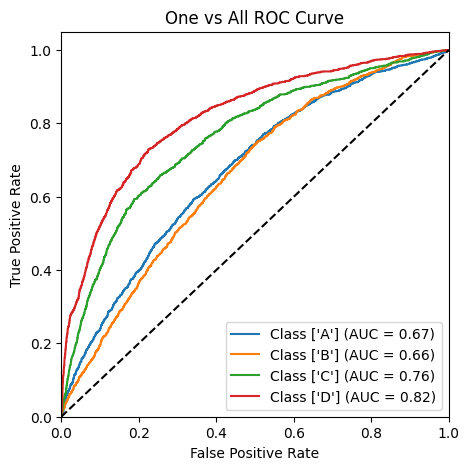

In [394]:
# calculate the fpr and tpr for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(logreg.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_train, logreg.predict_proba(X_train)[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot the ROC curve for each class
plt.figure(figsize=[5,5])
for i in range(len(logreg.classes_)):
    original_label = le.inverse_transform([logreg.classes_[i]])
    plt.plot(fpr[i], tpr[i], label='Class {} (AUC = {:.2f})'.format(original_label, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One vs All ROC Curve')
plt.legend(loc="lower right")
plt.show()

- Here AUCs ranges are varying greatly from 0.67 to 0.82 which again indicates imbalanced performance of the model for the balanced classes.
- Classes A and B had scores lower than acceptable (model has low performance for both classes).
- Class C had an acceptable score and Class D had an excellent score.

Plotting a confusion matrix

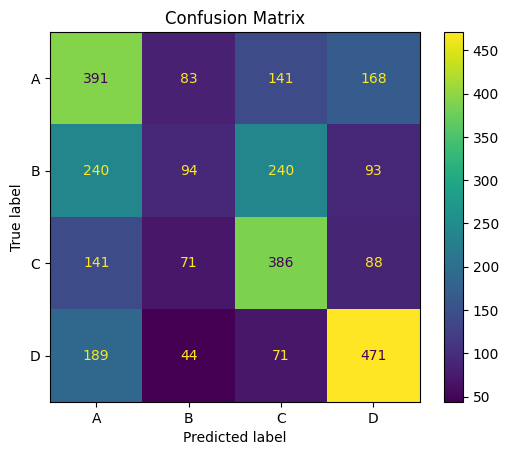

In [395]:
plot_confusion_matrix(y_test, y_pred, le)

Classes that are missclassified the most:

1- Class B is misclabeled as class A (24% of Class A's predictions)

2- Class B is misclabeled as class C (28.6% of Class C's predictions)

I would suggest adding new features that might help in distinguishing classes.

##### Decision Tree Classifier

A Decision Tree Classifier works by splitting the source set into subsets based on an attribute value test. This process is repeated on each derived subset in a recursive manner called recursive partitioning.

Here's a step-by-step breakdown of how a Decision Tree Classifier works:

1. **Choose the Best Feature**: The decision tree algorithm starts by choosing the feature that best splits the data. The "best" feature is often chosen using a metric like Information Gain or Gini Impurity.

2. **Create a Decision Node**: The algorithm creates a decision node on the tree representing the best feature. The data is then split into subsets based on the values of this feature.

3. **Recursive Splitting**: Steps 1 and 2 are then repeated on each subset, creating an increasingly fine partition of the data. This recursive process is known as "recursive partitioning".

4. **Stopping Criterion**: The recursion stops when a stopping criterion is met. This could be a maximum tree depth, a minimum node size, or no further improvement in the split metric.

5. **Assign Class Labels**: Once the stopping criterion is met, each leaf node is assigned a class label. For a classification problem, this is typically the most common class of the instances in the leaf.

Creating a decision tree classifier

Finding the best hyperparameters for the model

In [414]:
# create an instance of the model
dt = DecisionTreeClassifier()

# fit the model on the training data
dt.fit(X_train, y_train)

# define the hyperparameter grid
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': randint(low=1, high=10),
              'min_samples_split': randint(low=2, high=10),
              'min_samples_leaf': randint(low=1, high=10)}

# create a randomized search object
random_search = RandomizedSearchCV(estimator=dt, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)

# fit the randomized search object on the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print(random_search.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


Create an instance of the model with the best hyperparameters

In [415]:
dt = DecisionTreeClassifier(criterion=random_search.best_params_['criterion'], max_depth=random_search.best_params_['max_depth'], min_samples_split=random_search.best_params_['min_samples_split'], min_samples_leaf=random_search.best_params_['min_samples_leaf'])
dt.fit(X_train, y_train)

# predict the target variable for the test data
y_pred = dt.predict(X_test)

# perform cross-validation
scores = cross_val_score(dt, X_train, y_train, cv=5)

# calculate the error metrics
error_metrics(y_test, y_pred,le,scores)

Accuracy Score:  0.4706286499484713
Average cross-validation score:  0.4776556619114548
Precision Score:  0.46210065861801947
Recall Score:  0.4706286499484713
F1 Score:  0.46262896735177467


In [416]:
# get the effective alphas of the pruned tree
path = dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# create an instance of the model for each value of alpha
dts = [DecisionTreeClassifier(ccp_alpha=alpha) for alpha in ccp_alphas[:-1]]

# fit each model on the training data
for dt in dts:
    dt.fit(X_train, y_train)

# calculate the cross-validation error for each model
cv_errors = [1 - dt.score(X_test, y_test) for dt in dts]

# find the optimal value of alpha that minimizes the cross-validation error
optimal_alpha = ccp_alphas[np.argmin(cv_errors)]

# create an instance of the model with the optimal value of alpha
dt_pruned = DecisionTreeClassifier(criterion=random_search.best_params_['criterion'], max_depth=random_search.best_params_['max_depth'], min_samples_split=random_search.best_params_['min_samples_split'], min_samples_leaf=random_search.best_params_['min_samples_leaf'],ccp_alpha=optimal_alpha)

# fit the model on the training data
dt_pruned.fit(X_train, y_train)

# predict the target variable for the test data
y_pred = dt_pruned.predict(X_test)

# perform cross-validation
scores = cross_val_score(dt_pruned, X_train, y_train, cv=5)

# calculate the error metrics
error_metrics(y_test, y_pred,le,scores)


Accuracy Score:  0.4702851253864651
Average cross-validation score:  0.4776556619114548
Precision Score:  0.46178918627789045
Recall Score:  0.4702851253864651
F1 Score:  0.46234427101036446


Plotting the pruned decision tree to a depth of 5

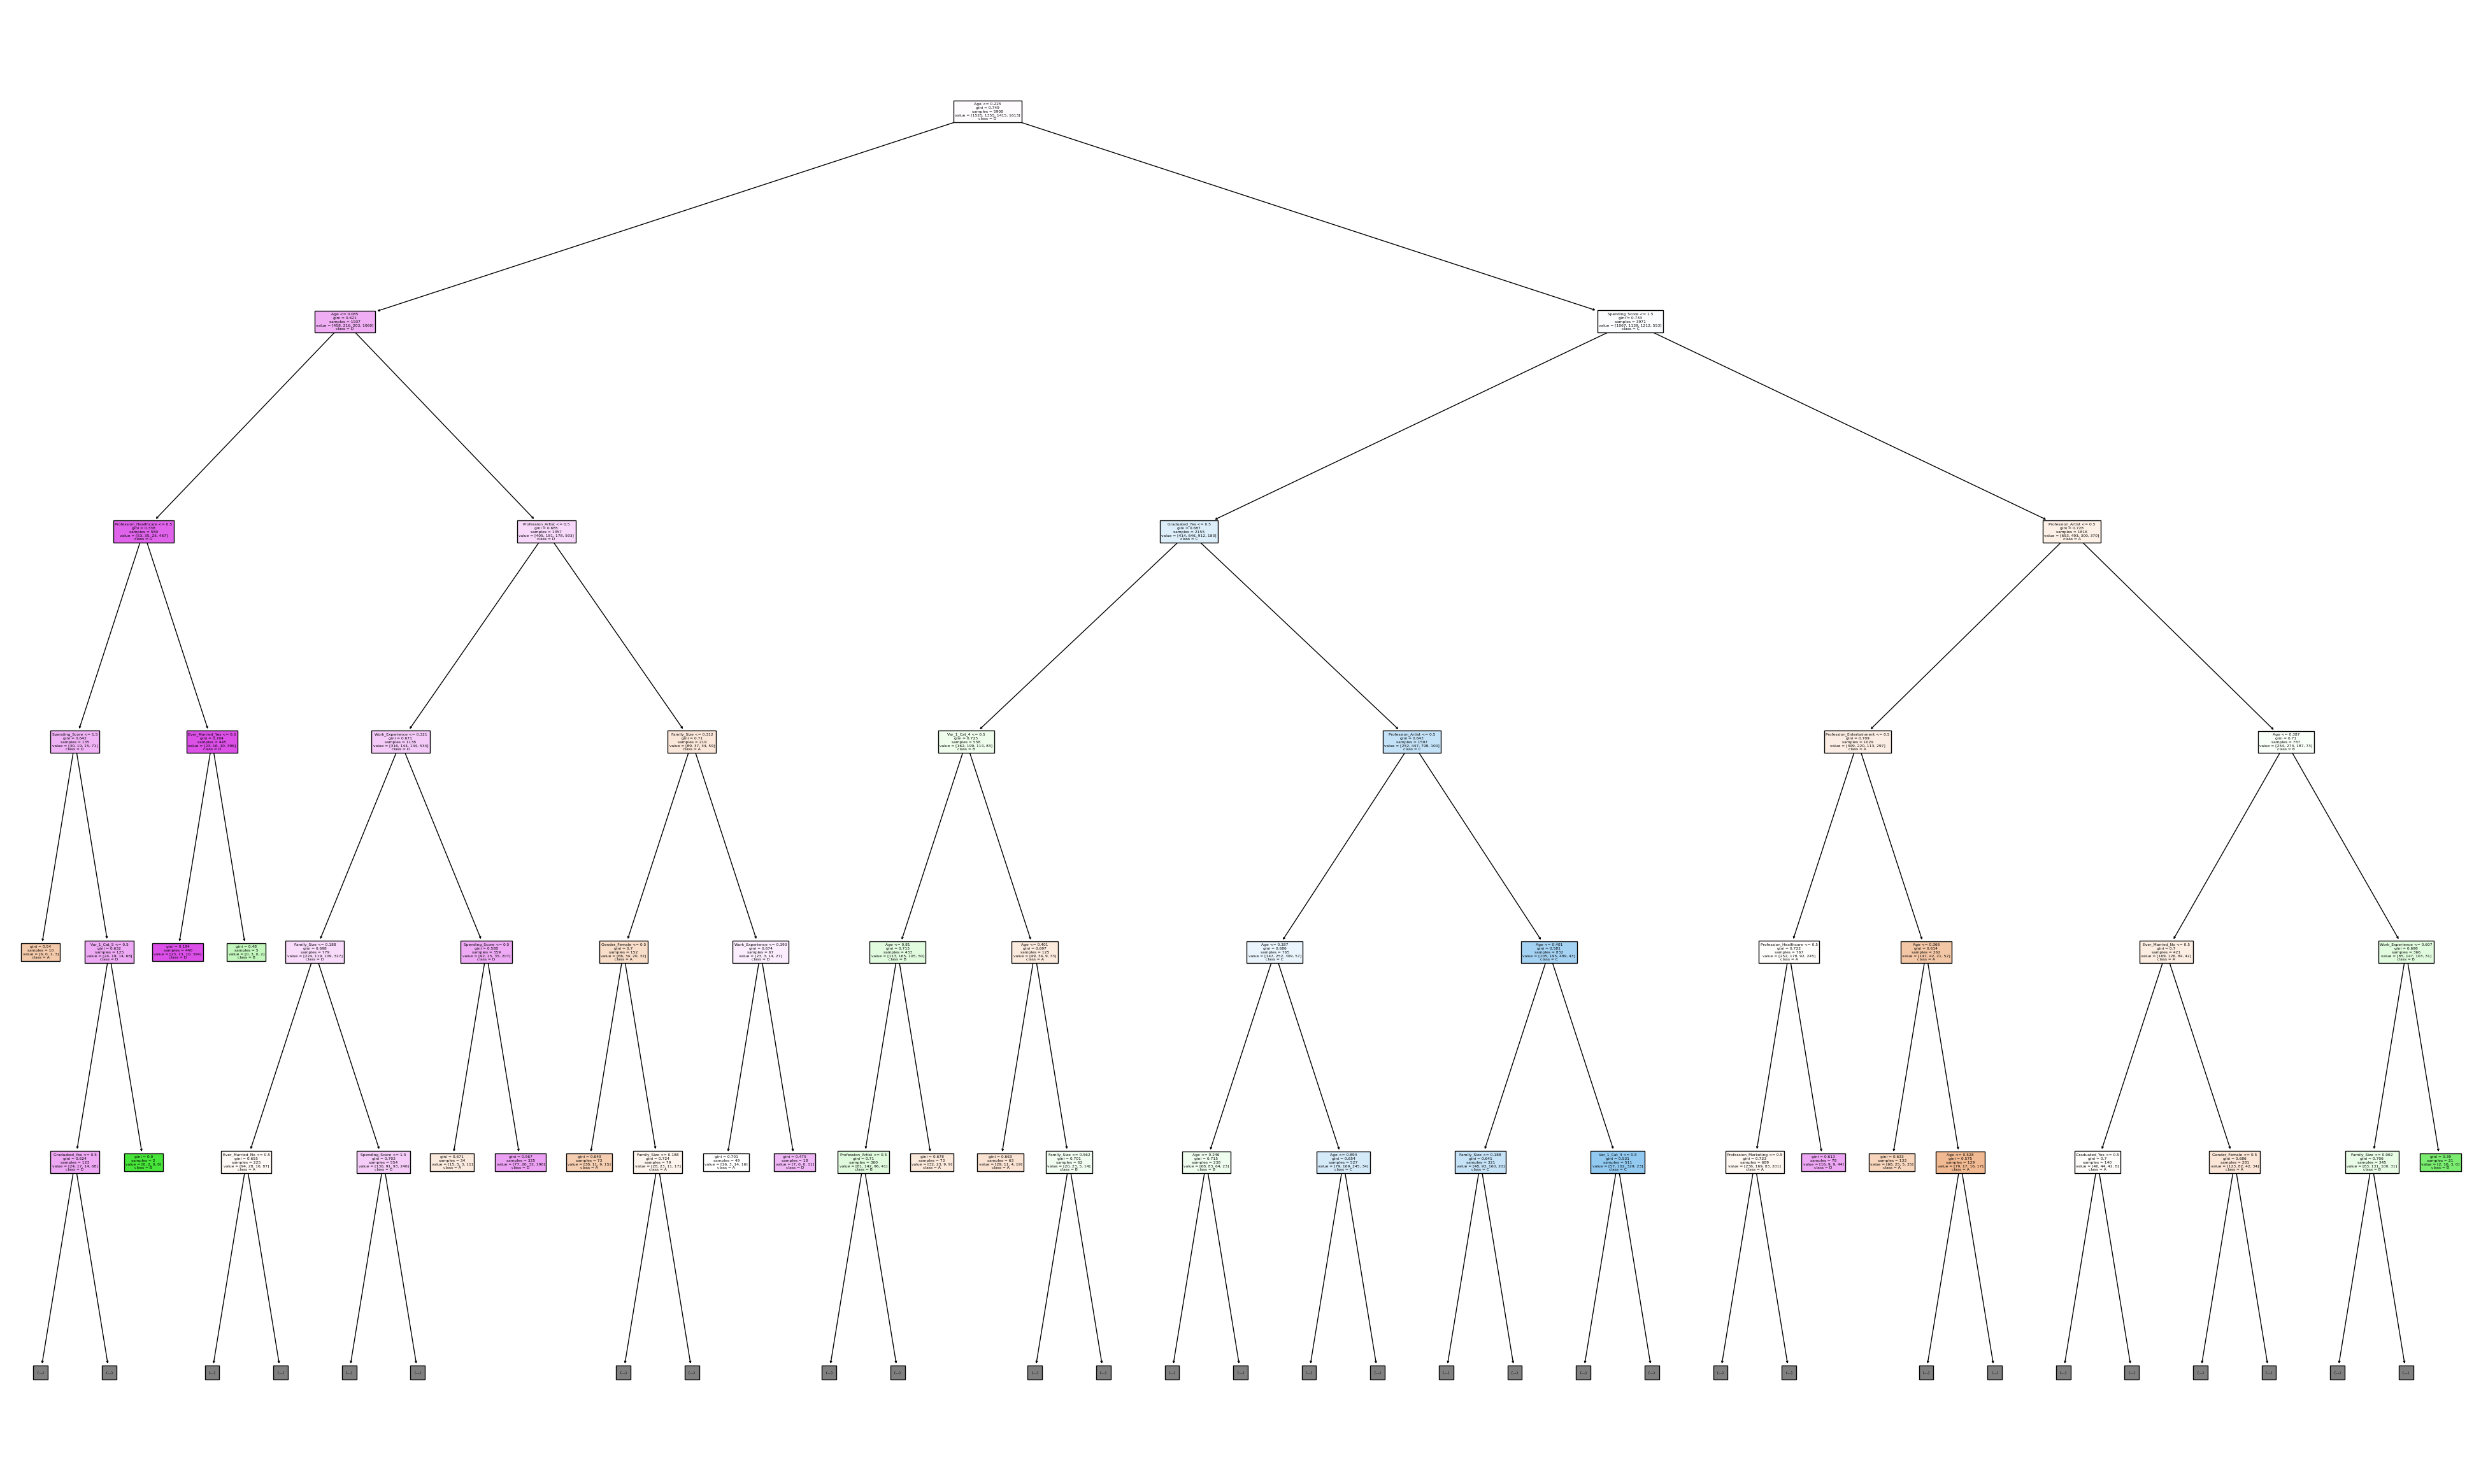

In [399]:
from sklearn.tree import plot_tree
plt.figure(figsize=(50,30))
plot_tree(dt_pruned, filled=True, feature_names=X.columns, class_names=le.classes_,max_depth=5)
plt.show()

Plotting the confusion matrix

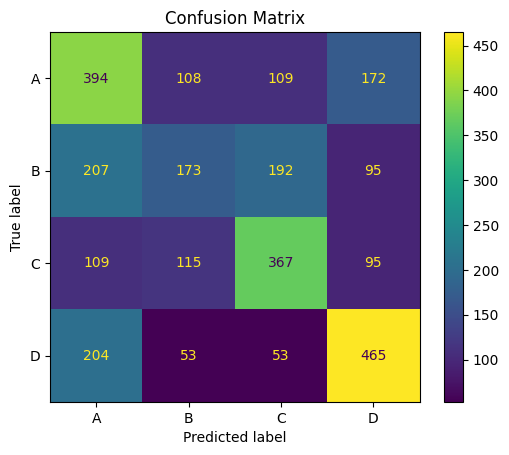

In [400]:
plot_confusion_matrix(y_test, y_pred, le)

Classes that are missclassified the most:

1- Class B is misclabeled as class A (22.6% of Class B's predictions)

2- Class D is misclabeled as class A (22.2% of Class C's predictions)

I would suggest adding new features that might help in distinguishing classes.

Identify the important features and train the pruned decision tree model on data with important features only

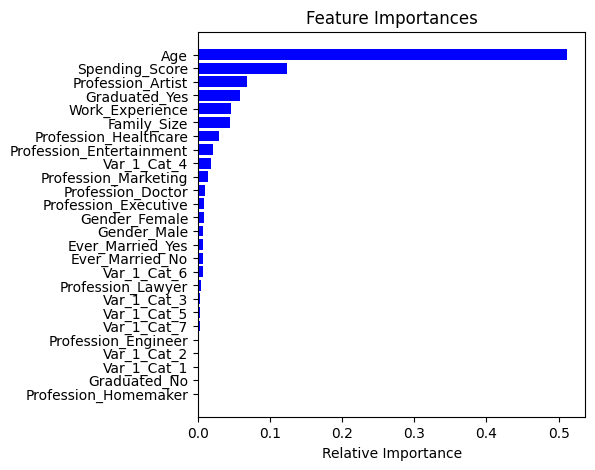

In [401]:
#feature importances (model.feature_importances_)
importance = dt_pruned.feature_importances_
features = X.columns
indices = np.argsort(importance)

plt.figure(figsize=[5,5])
plt.title('Feature Importances')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Making the model learn only on important features

In [418]:
# Identify the important features
important_features = X.columns[dt_pruned.feature_importances_ > 0]

# Filter the training and test data to include only the important features
X_train_filtered = X_train[important_features]
X_test_filtered = X_test[important_features]

# Fit the decision tree model on the filtered training data
dt_filtered = DecisionTreeClassifier(criterion=random_search.best_params_['criterion'], max_depth=random_search.best_params_['max_depth'], min_samples_split=random_search.best_params_['min_samples_split'], min_samples_leaf=random_search.best_params_['min_samples_leaf'],ccp_alpha=optimal_alpha)
dt_filtered.fit(X_train_filtered, y_train)

# Predict the target variable for the filtered test data
y_pred_filtered = dt_filtered.predict(X_test_filtered)

# Calculate the error metrics for the filtered test data
error_metrics(y_test, y_pred_filtered, le,scores)

Accuracy Score:  0.4702851253864651
Average cross-validation score:  0.4776556619114548
Precision Score:  0.46178918627789045
Recall Score:  0.4702851253864651
F1 Score:  0.46234427101036446


##### KNN

The k-Nearest Neighbors (k-NN) algorithm is a type of instance-based learning method used for both classification and regression. Here's a step-by-step breakdown of how a k-NN model works:

1. **Choose the number of k and a distance metric**: The algorithm starts by choosing the number of neighbors (k) and a distance metric (like Euclidean or Manhattan distance).

2. **Find the k-nearest neighbors**: For each instance that we need to make a prediction for, the algorithm finds the k instances in the training data that are closest to it.

3. **Make a prediction**: The prediction is made based on the labels or output values of the k-nearest neighbors:
   - For classification, the prediction is usually the most common class among the k-nearest neighbors.
   - For regression, the prediction could be the mean or median output value of the k-nearest neighbors.

Creating and fitting the model

In [403]:
# Create a k-NN classifier with 3 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Train the classifier on the training data
knn.fit(X_train, y_train)

# Use the classifier to make predictions on the test data
y_pred = knn.predict(X_test)

Finding the best hyperparameters for the model

In [404]:
# create an instance of the model
knn = KNeighborsClassifier()

# fit the model on the training data
knn.fit(X_train, y_train)

# define the hyperparameter grid
param_grid = {'n_neighbors': randint(low=1, high=25),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'leaf_size': randint(low=1, high=50)}

# create a randomized search object
random_search = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)

# fit the randomized search object on the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print(random_search.best_params_)


{'algorithm': 'ball_tree', 'leaf_size': 32, 'n_neighbors': 24, 'weights': 'uniform'}


Calculate the error for different values of k

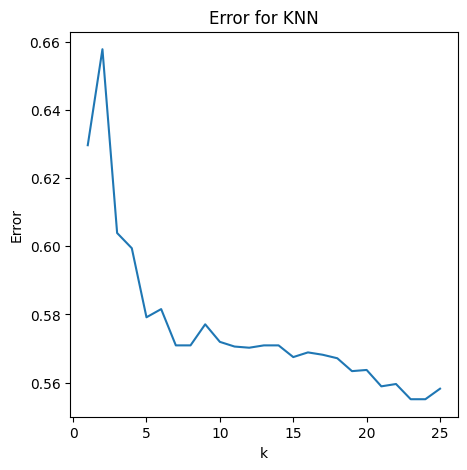

In [405]:
k_values = range(1, 26)
errors = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    errors.append(1 - accuracy_score(y_test, y_pred))

# plot the error for different values of k
plt.figure(figsize=[5,5])
plt.plot(k_values, errors)
plt.title('Error for KNN')
plt.xlabel('k')
plt.ylabel('Error')
plt.show()

In [406]:
print('Minimum error = ',min(errors),' at k = ',errors.index(min(errors))+1)

Minimum error =  0.5551356922019924  at k =  23


Create an instance of the model with the best hyperparameters

In [407]:
knn = KNeighborsClassifier(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'], algorithm=random_search.best_params_['algorithm'], leaf_size=random_search.best_params_['leaf_size'])

# fit the model on the training data
knn.fit(X_train, y_train)

# predict the target variable for the test data
y_pred = knn.predict(X_test)

# perform cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5)

# calculate the error metrics
error_metrics(y_test, y_pred,le,scores)

Accuracy Score:  0.44658193060803847
Average cross-validation score:  0.4600520652004166
Precision Score:  0.44216450252520445
Recall Score:  0.44658193060803847
F1 Score:  0.4437795527535611


Plotting a confusion matrix

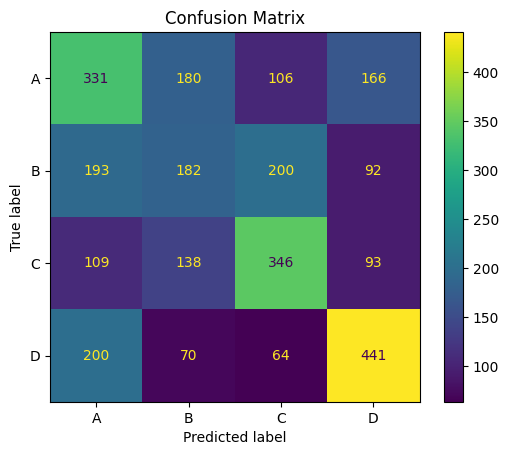

In [408]:
plot_confusion_matrix(y_test, y_pred, le)

##### boosting

Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning. It is a family of algorithms that convert weak learners to strong ones.

##### XGBoost

XGBoost stands for eXtreme Gradient Boosting. It's an implementation of gradient boosting machines that is more efficient and flexible than the standard version. Here's a step-by-step breakdown of how XGBoost works:

1. **Initialize a Base Model**: XGBoost starts by initializing a base model. This could be a simple model that makes a single prediction for all instances, such as predicting the mean output value.

2. **Calculate the Residuals**: The residuals (differences between the predictions and the actual values) are calculated. These residuals represent the errors made by the base model.

3. **Train a New Model on Residuals**: A new model is trained to predict the residuals instead of the actual output values. This model is trying to correct the errors made by the previous model.

4. **Update the Predictions**: The predictions are updated by adding the predictions of the new model (multiplied by a learning rate) to the old predictions.

5. **Repeat Steps 2-4**: Steps 2-4 are repeated for a specified number of iterations. Each iteration adds a new model that tries to correct the errors made by the combined models from the previous iterations.

6. **Make Final Predictions**: The final predictions are made by summing the predictions of all models.

XGBoost also includes several advanced features that make it more powerful and flexible than standard gradient boosting:

- **Regularization**: XGBoost includes L1 (Lasso Regression) and L2 (Ridge Regression) regularization to prevent overfitting.

- **Tree Pruning**: Unlike Gradient Boosting which stops splitting a node as soon as it encounters a negative loss, XGBoost splits up to the max_depth specified and then starts pruning the tree backwards and removes splits beyond which there is no positive gain.

- **Handling Missing Values**: XGBoost has an in-built routine to handle missing values.

- **Built-in Cross-Validation**: XGBoost allows user to run a cross-validation at each iteration of the boosting process and thus it is easy to get the exact optimum number of boosting iterations in a single run.

Creating the model and finding best hyperparameters

In [409]:
# create an instance of the model
xgb = XGBClassifier()

# fit the model on the training data
xgb.fit(X_train, y_train)

# define the hyperparameter grid
param_grid = {'max_depth': randint(low=1, high=10),
              'learning_rate': uniform(loc=0, scale=1),
              'n_estimators': randint(low=50, high=200),
              'gamma': uniform(loc=0, scale=1),
              'subsample': uniform(loc=0, scale=1),
              'colsample_bytree': uniform(loc=0, scale=1)}

# create a randomized search object
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=100, cv=5, random_state=42)

# fit the randomized search object on the training data
random_search.fit(X_train, y_train)

# print the best hyperparameters
print(random_search.best_params_)

# create an instance of the model with the best hyperparameters
xgb = XGBClassifier(max_depth=random_search.best_params_['max_depth'], learning_rate=random_search.best_params_['learning_rate'], n_estimators=random_search.best_params_['n_estimators'], gamma=random_search.best_params_['gamma'], subsample=random_search.best_params_['subsample'], colsample_bytree=random_search.best_params_['colsample_bytree'])

# fit the model on the training data
xgb.fit(X_train, y_train)

# predict the target variable for the test data
y_pred = xgb.predict(X_test)

# perform cross-validation
scores = cross_val_score(xgb, X_train, y_train, cv=5)

# calculate the error metrics
error_metrics(y_test, y_pred,le,scores)

{'colsample_bytree': 0.9491457315913859, 'gamma': 0.8866803872980475, 'learning_rate': 0.26089362334171395, 'max_depth': 3, 'n_estimators': 145, 'subsample': 0.8564898411883223}
Accuracy Score:  0.4864307798007558
Average cross-validation score:  0.4932263661384212
Precision Score:  0.478203040743631
Recall Score:  0.4864307798007558
F1 Score:  0.47958437575071533


##### Comparing between models

In [419]:
# create a dictionary to store the error metrics for each model
models = {'Logistic Regression': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
          'Decision Tree': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
          'KNN': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0},
          'XGBoost': {'Accuracy': 0.0, 'Precision': 0.0, 'Recall': 0.0, 'F1': 0.0}}

# calculate the error metrics for each model
y_preds = {'Logistic Regression': logreg.predict(X_test),
           'Decision Tree': dt_pruned.predict(X_test),
           'KNN': knn.predict(X_test),
           'XGBoost': xgb.predict(X_test)}

for model_name, y_pred in y_preds.items():
    models[model_name]['Accuracy'] = accuracy_score(y_test, y_pred)
    models[model_name]['Precision'] = precision_score(y_test, y_pred, average='weighted')
    models[model_name]['Recall'] = recall_score(y_test, y_pred, average='weighted')
    models[model_name]['F1'] = f1_score(y_test, y_pred, average='weighted')

# create a dataframe from the dictionary
df_models = pd.DataFrame(models).T
df_models

,Accuracy,Precision,Recall,F1
Logistic Regression,0.461010,0.444670,0.461010,0.442138
Decision Tree,0.470285,0.461789,0.470285,0.462344
KNN,0.446582,0.442165,0.446582,0.443780
XGBoost,0.486431,0.478203,0.486431,0.479584


#### Conclusion and notes

Based on the error metrics calculated for each model, it appears that none of the four models achieved an accuracy score higher than 50%, although it is much better than a coin flip, which would be of 25% accuracy, This could be due to a number of factors, such as the size and quality of the dataset, the complexity of the problem being solved, or the choice of features and hyperparameters used in each model.

XGBoost performed the best among the models, with the highest accuracy, precision, recall, and F1 score. Therefore, XGBoost would be the recommended model to use for now. It is important to note that further iterations and refinements may be necessary to improve the performance of the models.